In [1]:
#=====================================================================
# gpt2 모델을 새롭게 만드는 예제
#
# [과정]

# 1. Sentencepiece tokenizer 생성
# => 생성은 toeknzier/new_token.ipynb 참조
# => 여기서는 만들어진 tokenizer를 사용 함
#
# 2. 빈껍데기 GPT-2 모델 생성 
# => **반드시 위 vocab_size와 같은 크기로 word_embedding 사이즈 설정해야 함
#
# 3. 훈련
# => vocab 만들때 동일한 말뭉치를 훈련 데이터로 사용
#
# 4. 모델과 tokenizer 저장

#=====================================================================
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler 
from transformers import GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

from tqdm.notebook import tqdm
import os
import time
from myutils import GPU_info, seed_everything, mlogging, SaveBERTModel, TextGeneration_Dataset

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="gpt2-scratch", logfilename="../log/gpt2-scratch")

model_path = '../model/gpt-2/mymodel'
OUTPATH = '../model/gpt-2/mymodel_scratch'

logfilepath:../log/bwdataset_2022-05-18.log
logfilepath:../log/qnadataset_2022-05-18.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../log/gpt2-scratch_2022-05-18.log


In [2]:
# 1. Sentencepiece tokenizer 로딩 
# => 반드시 bos_token, eos_token, unk_token, pad_token, mask_token 들은 tokenizer 생성할때 사용한 vocab을 지정해야 함
# => 생성은 toeknzier/new_token.ipynb 참조
# => 여기서는 만들어진 tokenizer를 사용 함
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path,
                                                   bos_token='<cls>',
                                                   eos_token='<eos>',
                                                   unk_token='<unk>',
                                                   pad_token='<pad>',
                                                   mask_token='<mask>')

vocab_size = len(tokenizer.get_vocab())
print(f'*vocab_size:{vocab_size}')

*vocab_size:10661


In [3]:
# tokenizer 테스트 
sentence = "오늘은 날씨가 좋다"
encode = tokenizer.encode(sentence)
print(encode)
decode = tokenizer.decode(encode)
print(decode)

[2448, 703, 7074, 120, 2309, 271]
오늘은 날씨가 좋다


In [4]:
# 2. 빈껍데기 GPT-2 모델 생성 
# => **반드시 위 vocab_size와 같은 크기로 word_embedding 사이즈 설정해야 함
configuration = GPT2Config(vocab_size=vocab_size)
model = GPT2LMHeadModel(config=configuration) 
model.to(device)
print(model.num_parameters())


94030080


In [5]:
# vocab_size가 잘 설정되었는지 모델 출력 확인
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(10661, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [6]:
# 3.훈련
# => vocab 만들때 동일한 말뭉치를 불러옴 
corpus_path = "../korpora/kowiki_20190620/wiki_20190620_small.txt"
all_sentences = []

with open(corpus_path, 'r', encoding='utf-8') as f:
      for line in tqdm(f):
            all_sentences.append(line.strip())  # strip() 계행문자 제거
            
print(all_sentences[10:15])
print(len(all_sentences))

0it [00:00, ?it/s]

['카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.', '카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.', '그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다.', '1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다.', '또한 소련과 제2차 전략 무기 제한 협상에 조인했다.']
10000


In [7]:
# 최대 토큰 계수를 구함.
max_token_len = max([len(tokenizer.encode(s)) for s in tqdm(all_sentences)])
print(f'max_token_len:{max_token_len}')

  0%|          | 0/10000 [00:00<?, ?it/s]

max_token_len:180


In [8]:
# TextGenerattion 데이터셋 생성
# => bos_token + 문장 + eos_token
dataset = TextGeneration_Dataset(all_sentences, tokenizer, max_length=max_token_len)
print(dataset[10:13])

  0%|          | 0/10000 [00:00<?, ?it/s]

([tensor([   0, 5494, 3122, 1277, 9989, 5260,  168, 3183, 3360, 3814, 5100, 1139,
         539, 1261, 1554,    1,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4, 

In [9]:
# 훈련 데이터와 test 데이터를 나눔
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

print(f'train_size:{len(train_set)}')
print(f'val_size:{len(val_set)}')

train_size:9900
val_size:100


In [10]:
# dataloader 생성
batch_size = 32
train_loader = DataLoader(train_set, sampler = RandomSampler(train_set), batch_size=batch_size)
eval_loader = DataLoader(val_set, sampler = RandomSampler(val_set), batch_size=batch_size)

for val_data in eval_loader:
    print(val_data)
    break

[tensor([[    0,  1138,  1732,  ...,     4,     4,     4],
        [    0,  1673,   405,  ...,     4,     4,     4],
        [    0,  3061,  1687,  ...,     4,     4,     4],
        ...,
        [    0,  2460,  4116,  ...,     4,     4,     4],
        [    0,  1094,   790,  ...,     4,     4,     4],
        [    0, 10648,   707,  ...,     4,     4,     4]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])]


In [11]:
decode = tokenizer.decode([0,1406, 1])
print(decode)

<cls> 즉,<eos>


In [12]:
tokenizer.bos_token

'<cls>'

In [13]:
# 훈련 시작 

##################################################
epochs = 10            # epochs
learning_rate = 3e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(total_steps*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1

total_loss = 0
total_test_len = 0
total_test_loss = 0
total_test_loss_count = 0

list_train_loss = []
list_validation_loss = []

# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
model.zero_grad(set_to_none=True)
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
        
        # 입력 값 설정
        input_ids = data[0].to(device)
        attention_mask = data[1].to(device)
        
         # labels은 input_ids와 동일하게 입력 (*GPT2LMHeadModel 을 이용하는 경우, 내부적으로 labels 값에 대해 shift 연산처리를 해서 손실 구함)
        labels = data[0].to(device)  
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # logits_shape: torch.Size([32, 68, 51200])
        # => batch_size, sequence_max_len, token_len
        #print(f'logits_shape: {logits.shape}')                    
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
                
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                #train_acc = total_correct/total_len
                
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()
                for data in tqdm(eval_loader):
                #for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data[0].to(device)
                    attention_mask = data[1].to(device)
                    labels = data[0].to(device)
                    
                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        loss = outputs.loss
                        logits = outputs.logits
                        
                        total_test_loss += loss.item()
                        total_test_loss_count += 1
                        
                val_loss = total_test_loss/total_test_loss_count
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Val Loss: {}'.format(epoch+1, epochs, itr, train_loss, val_loss))
                    
                list_train_loss.append(train_loss)
                list_validation_loss.append(val_loss)
                 
                # 변수들 초기화    
                total_loss = 0
                total_test_loss = 0
                total_test_len = 0
                total_test_loss_count = 0
                ####################################################################
            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:39:12,199 - gpt2-scratch - INFO - [Epoch 1/10] Iteration 310 -> Train Loss: 1.4370, Val Loss: 1.2207323014736176


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:40:21,170 - gpt2-scratch - INFO - [Epoch 2/10] Iteration 620 -> Train Loss: 1.0132, Val Loss: 1.0779387801885605


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:41:31,947 - gpt2-scratch - INFO - [Epoch 3/10] Iteration 930 -> Train Loss: 0.9821, Val Loss: 0.9797493815422058


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:42:45,522 - gpt2-scratch - INFO - [Epoch 4/10] Iteration 1240 -> Train Loss: 0.9445, Val Loss: 1.0073799788951874


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:43:58,239 - gpt2-scratch - INFO - [Epoch 5/10] Iteration 1550 -> Train Loss: 0.9085, Val Loss: 1.0001187324523926
2022-05-18 13:43:58,763 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/mymodel_scratchbatch:32-ep:10-lr:0.000030000-5m18d-13:43


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:45:10,983 - gpt2-scratch - INFO - [Epoch 6/10] Iteration 1860 -> Train Loss: 0.8781, Val Loss: 0.9615229517221451


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:46:22,928 - gpt2-scratch - INFO - [Epoch 7/10] Iteration 2170 -> Train Loss: 0.8530, Val Loss: 0.9699893593788147


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:47:31,896 - gpt2-scratch - INFO - [Epoch 8/10] Iteration 2480 -> Train Loss: 0.8329, Val Loss: 0.9173761606216431


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:48:41,169 - gpt2-scratch - INFO - [Epoch 9/10] Iteration 2790 -> Train Loss: 0.8169, Val Loss: 0.9672838449478149


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2022-05-18 13:49:50,875 - gpt2-scratch - INFO - [Epoch 10/10] Iteration 3100 -> Train Loss: 0.8054, Val Loss: 1.011869192123413
2022-05-18 13:49:51,375 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/mymodel_scratchbatch:32-ep:10-lr:0.000030000-5m18d-13:49


In [14]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

2022-05-18 13:49:51,972 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/mymodel_scratchbatch:32-ep:10-lr:0.000030000-5m18d-13:49


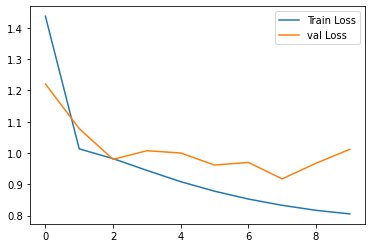

In [15]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
plt.plot(list_validation_loss, label='val Loss')
plt.legend()
plt.show()